In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

from absl import app
from absl import flags
from absl import logging
import pickle


import tensorflow as tf
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.metrics import log_loss, accuracy_score
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten

import os
import sys
from tensorflow.python.keras.utils import to_categorical

1.15.2


In [2]:

STOPWORDS = set(stopwords.words('english'))

import pandas as pd
from sklearn import preprocessing


from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Concatenate, Dropout




In [3]:
df = pd.read_csv('consumer_complaints.csv')



/Users/armandoordoricadelatorre/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
graph = tf.get_default_graph()

In [5]:
def get_embedding_matrix(word_index):
    
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)), encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words

def data_preprocessing(texts, labels, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    if classifier == "NeuralNetwork":
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        
        plt.figure()
        plt.hist([len(x) for x in sequences])
        plt.xlabel('Length of Document')
        plt.ylabel('Number of Documents')
        plt.title('Statistic of Data')
        plt.grid(True)
        plt.show()
        
        word_index = tokenizer.word_index
        
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        
    else:
        vectorizer = TfidfVectorizer()
        data = vectorizer.fit_transform(texts)
    
    labels = to_categorical(np.asarray(labels))  
    data = data[indices]
    labels = labels[indices]

    x_train = data[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    x_val = data[-num_validation_samples:]
    y_val = labels[-num_validation_samples:]
    
    return x_train, y_train, x_val, y_val, word_index    

def get_data(data_path):
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_path)):
        path = os.path.join(data_path, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # Skip header which contains label!!!
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)
    return texts, labels_index, labels

In [6]:
consumer_PATH = "consumer_complaints.csv"
GLOVE_DIR = "glove_6B/"

TEXT_DATA_DIR = consumer_PATH
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.4

In [7]:
import pandas as pd
import re
import itertools
import string
from io import BytesIO
from collections import Counter
from time import time
import datetime
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [8]:

def clean_str(string):
    """
    Tokenization/string cleaning (partially modified)
    """
    string = re.sub(r"[^A-Za-z0-9()!?\'\`%$]", " ", string) # keep also %$ but removed comma
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\$", " $ ", string) #yes, isolate $
    string = re.sub(r"\%", " % ", string) #yes, isolate %
    string = re.sub(r"\s{2,}", " ", string)
    
    # fixing XXX and xxx like as word
    string = re.sub(r'\S*(x{2,}|X{2,})\S*',"xxx",string)
    # removing non ascii
    string = re.sub(r'[^\x00-\x7F]+', "", string) 
    
    return string.strip().lower()

In [9]:
def get_complaints(path):
    
    # Read the input dataset 
    d = pd.read_csv(path, 
                    usecols=('product','consumer_complaint_narrative'),
                    dtype={'consumer_complaint_narrative': object})
    # Only interested in data with consumer complaints
    d=d[d['consumer_complaint_narrative'].notnull()]
    d=d[d['product'].notnull()]
    d.reset_index(drop=True,inplace=True)
    d['consumer_complaint_narrative'] = d['consumer_complaint_narrative'].apply(clean_str)
    
    le = preprocessing.LabelEncoder()
    label_name = d['product'].tolist()
    le.fit(label_name)
    d['label'] = le.transform(label_name)
    return d['consumer_complaint_narrative'].tolist(), d['product'].tolist(), d['label'].tolist()

In [10]:
texts, labels_index, labels = get_complaints(TEXT_DATA_DIR)


In [11]:
indices = np.arange(len(texts))
np.random.shuffle(indices)
num_validation_samples = int(VALIDATION_SPLIT * len(texts))

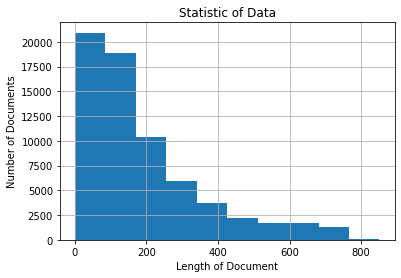

In [12]:
x_train, y_train, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels, 
                                                                indices, 
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [13]:
embedding_matrix, num_words = get_embedding_matrix(word_index)

In [ ]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()
with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train 2 Layer LSTM model with first LSTM to bidirectional
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x1 = LSTM(EMBEDDING_DIM, return_sequences=True)(embedded_sequences)
    x2 = LSTM(EMBEDDING_DIM, return_sequences=True, go_backwards=True)(embedded_sequences)
    x = Concatenate()([x1, x2])
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(x) # Note: this layer takes previous LSTM layer as input!
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    preds = Dense(11, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                         batch_size=128,
                         epochs=1, # Change this to at least 20 for final run
                         validation_data=(x_val, y_val))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training model.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40084 samples, validate on 26722 samples
 2560/40084 [>.............................] - ETA: 25:46 - loss: 2.0055 - acc: 0.2578

In [ ]:
x_val.shape

In [ ]:
y_val.shape

In [ ]:
break

In [ ]:
word_index = None


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

plt.figure()
plt.hist([len(x) for x in sequences])
plt.xlabel('Length of Document')
plt.ylabel('Number of Documents')
plt.title('Statistic of Data')
plt.grid(True)
plt.show()

word_index = tokenizer.word_index

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


# labels = to_categorical(np.asarray(labels))  
# data = data[indices]
# labels = labels[indices]

# x_train = data[:-num_validation_samples]
# y_train = labels[:-num_validation_samples]
# x_val = data[-num_validation_samples:]
# y_val = labels[-num_validation_samples:]

# return x_train, y_train, x_val, y_val, word_index

In [ ]:
labels = to_categorical(np.asarray(labels))  
data = data[indices]
labels = labels[indices]

In [ ]:
labels.shape

In [ ]:
data.shape

In [ ]:
x_train = data[:-num_validation_samples]

In [ ]:
y_train = labels[:-num_validation_samples]

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
x_val.shape

In [ ]:
y_val.shape

In [ ]:
len(labels_index)